In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
%matplotlib inline
import os
os.listdir()

['user_info.csv',
 'listing_info.csv',
 'submission.zip',
 '.ipynb_checkpoints',
 'dogscats',
 'user_behavior_logs.csv',
 'user_taglist.csv',
 'user_repay_logs.csv',
 'EDA.ipynb',
 'train.csv',
 'test.csv']

In [32]:
train_data = pd.read_csv("train.csv")
train_data['train']=1
test_data = pd.read_csv("test.csv")
test_data['train']=0
train_data[train_data.repay_date=='\\N'].shape[0]/len(train_data)
train_data['yq_flag'] = train_data.repay_date=='\\N'
listing_info = pd.read_csv('listing_info.csv')

In [33]:
total_data = pd.concat([train_data[['user_id', 'listing_id', 'auditing_date', 'due_date', 'due_amt','train']],test_data])
total_data = total_data.merge(listing_info,on=['user_id', 'listing_id','auditing_date'])

训练集是2018年1月到2018年12月的部分数据，测试集是19年前两个月的数据

In [22]:
pd.crosstab(total_data['auditing_date'].str[:7],total_data['train'])

train,0,1
auditing_date,,
2018-01,0,51591
2018-02,0,53366
2018-03,0,87050
2018-04,0,115145
2018-05,0,114167
2018-06,0,92796
2018-07,0,71249
2018-08,0,57625
2018-09,0,73257


In [50]:
total_data.columns

Index(['user_id', 'listing_id', 'auditing_date', 'due_date', 'due_amt',
       'train', 'term', 'rate', 'principal'],
      dtype='object')

In [106]:
train_data_cp = total_data.query('train==1').merge(
    train_data[['user_id', 'listing_id', 'auditing_date','yq_flag','repay_amt','repay_date']],on=['user_id', 'listing_id', 'auditing_date'])
train_data_cp['auditing_date'] = train_data_cp['auditing_date'].str[:7]
train_data_cp['principal'] = train_data_cp['principal']//5000
train_data_cp['amt_diff']= train_data_cp.apply(lambda x:round(x.due_amt,3)-float(x.repay_amt) if x.yq_flag==0 else -1,axis=1)

In [110]:
import datetime as dt

In [112]:
train_data_cp['days_diff'] = train_data_cp.apply(lambda x: (dt.datetime.strptime(x.due_date,'%Y-%m-%d')-
                                                            dt.datetime.strptime(x.repay_date,'%Y-%m-%d')).days if x.yq_flag==0 else -1,axis=1)

In [45]:
for col in ['auditing_date','term','rate','principal']:
    print (col)
    temp = pd.crosstab(train_data_cp[col],train_data_cp['yq_flag'])
    print (pd.concat([temp,temp.apply(lambda x:x/x.sum(),axis=1)],axis=1))
#     plt.figure(figsize=(12,8))
#     sns.violinplot(x=col, y='yq_flag', data=train_data_cp)
#     plt.xlabel(col, fontsize=12)
#     plt.ylabel('if default', fontsize=12)
#     plt.show()

auditing_date
yq_flag         False  True      False     True 
auditing_date                                   
2018-01         44710   6881  0.866624  0.133376
2018-02         46923   6443  0.879268  0.120732
2018-03         75673  11377  0.869305  0.130695
2018-04        101398  13747  0.880611  0.119389
2018-05        100073  14094  0.876549  0.123451
2018-06         81456  11340  0.877796  0.122204
2018-07         63445   7804  0.890469  0.109531
2018-08         51517   6108  0.894004  0.105996
2018-09         65237   8020  0.890522  0.109478
2018-10         77234   9551  0.889946  0.110054
2018-11         81077   9649  0.893647  0.106353
2018-12         94065  12178  0.885376  0.114624
term
yq_flag   False  True      False     True 
term                                      
3         76795   8532  0.900008  0.099992
6        361441  48615  0.881443  0.118557
9        316021  46710  0.871227  0.128773
12       128551  13335  0.906016  0.093984
rate
yq_flag   False  True      False

从未逾期提前还款的角度分析,所有提前还款的金额都是当期应还金额，不存在部分还款，唯一的区别就是还款日期的早晚

### 借款用户基础信息表

In [63]:
user_info = pd.read_csv("user_info.csv")

In [66]:
#一共是928195个userid，其中26001个userid存在信息变更
user_info.user_id.nunique() 
sum(user_info.groupby('user_id').size().sort_values()>1)

928195

In [148]:
user_info['reg_mon'] = user_info['reg_mon'].map(lambda x:dt.datetime.strptime(x+'-01',"%Y-%m-%d"))
user_info['insertdate'] = user_info['insertdate'].map(lambda x:dt.datetime.strptime(x,"%Y-%m-%d"))

用户每次申请如果和之前的信息发生变化都会生成一条新的记录但是user_id不变,但是user_info的总量和total_data并不相同，这是同一个用户在同一年中申请了多次贷款导致的

在衍生用户信息特征时时，重点关注用户手机号是否有变动手机号及注册日期与插入日期的时间差

### 借款用户画像表

In [78]:
user_taglist = pd.read_csv("user_taglist.csv")

In [97]:
user_taglist.head()

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02


In [95]:
#统计画像词频
from collections import Counter

In [ ]:
#用户画像关注点 1.标签具体含义，tag embedding

In [92]:
taglists = user_taglist.taglist.map(lambda x:x.split('|')).values.tolist()

In [149]:
user_info[user_info.user_id.isin(train_data[train_data.yq_flag==0].user_id)].apply(
    lambda x:(x.insertdate-x.reg_mon).days,axis=1).describe()

count    755321.000000
mean        517.242259
std         317.841300
min          -1.000000
25%         275.000000
50%         469.000000
75%         708.000000
max        3942.000000
dtype: float64

In [150]:
user_info[user_info.user_id.isin(train_data[train_data.yq_flag==1].user_id)].apply(
    lambda x:(x.insertdate-x.reg_mon).days,axis=1).describe()

count    114950.000000
mean        529.938538
std         316.389584
min           1.000000
25%         286.000000
50%         483.000000
75%         726.000000
max        3958.000000
dtype: float64

逾期用户相对非逾期用户注册到首次提供标的时间要更久一些

### 用户操作行为日志表

用户操作行为关注点:观察成交日前最近6个月的用户操作行为，比如相邻两天最大，最小间隔，单天最多操作次数，分类聚合
用户行为信息的主要作用是识别反欺诈风险，防止羊毛党，所以主要的工作是识别异常行为，

In [180]:
user_behavior.behavior_type.value_counts()

1    43469932
3    11303679
2     1007660
Name: behavior_type, dtype: int64

In [116]:
user_behavior = pd.read_csv('user_behavior_logs.csv')

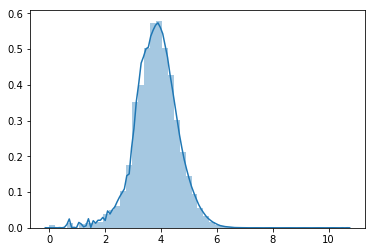

In [174]:
#用户总行为次数统计,次数的对数符合正态分布，均值在54次左右
sns.distplot(np.log(user_behavior.groupby('user_id').size().values))

用户操作行为日志 最早只记录到2017年7月的数据，所以我们假设2018年1月份的用户最早可以追溯到2017年7月所以，所以统一时间回溯范围为6个月,同时为了防止leakage，用户行为日志只保留合同生效前的数据

### 用户还款日志表

用户还款日志主要观察用户还款行为习惯，这对提前还款的天数预测非常重要，主要关注平均还款提前天数

In [177]:
user_repay_logs = pd.read_csv("user_repay_logs.csv")

In [178]:
user_repay_logs.head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
0,748483,1858122,6,2018-06-29,528.6365,2018-06-20,528.6365
1,748483,1858122,4,2018-04-29,528.6365,2200-01-01,528.6365
2,748483,1858122,7,2018-07-29,528.6365,2018-06-20,528.6365
3,748483,1858122,5,2018-05-29,528.6365,2018-05-29,528.6365
4,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365


In [182]:
user_repay_logs.groupby('user_id').order_id.max().describe()

count    874841.000000
mean          7.724069
std           3.596788
min           1.000000
25%           5.000000
50%           7.000000
75%          12.000000
max          12.000000
Name: order_id, dtype: float64

In [ ]:
a=[1,2,3,[1,2,3]]

In [ ]:
a